In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from contractions import contractions_dict
def expand_contractions(text, contraction_map=None):
    if contraction_map is None:
        contraction_map = contractions_dict

    # Using regex for getting all contracted words
    contractions_keys = '|'.join(re.escape(key) for key in contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    expanded_text = contractions_pattern.sub(lambda match: contraction_map.get(match.group(0), match.group(0)), text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [3]:
entertainment = pd.read_csv('data/BBCNewsSummaryCSV/entertainment_data.csv') 
sport = pd.read_csv('data/BBCNewsSummaryCSV/sport_data.csv')
tech = pd.read_csv('data/BBCNewsSummaryCSV/tech_data.csv')
business = pd.read_csv('data/BBCNewsSummaryCSV/business_data.csv')
politics = pd.read_csv('data/BBCNewsSummaryCSV/politics_data.csv')

In [4]:
training_dataset = pd.concat([business,politics,tech], ignore_index=True)
testing_dataset = pd.concat([entertainment,sport], ignore_index=True)

In [5]:
print("Training size:",training_dataset.size)
print("Testing size:",testing_dataset.size)

Training size: 3984
Testing size: 2691


In [6]:
training_dataset = training_dataset.sample(frac=1).reset_index(drop=True)
testing_dataset = testing_dataset.sample(frac=1).reset_index(drop=True)

In [7]:
training_dataset['newsarticle'] = training_dataset['newsarticle'].apply(expand_contractions)
testing_dataset['newsarticle'] = testing_dataset['newsarticle'].apply(expand_contractions)

In [8]:
def getSenLen(sentence):
    return len(sentence.split())

In [9]:
training_dataset['article_length'] = training_dataset['newsarticle'].apply(getSenLen)
training_dataset['summary_length'] = training_dataset['summary'].apply(getSenLen)
testing_dataset['article_length'] = testing_dataset['newsarticle'].apply(getSenLen)
testing_dataset['summary_length'] = testing_dataset['summary'].apply(getSenLen)


In [10]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,politics_168,MPs murder sentence concern\n\nMurder sentence...,Murder sentences should not be reduced automat...,604,286
1,tech_131,Seamen sail into biometric future\n\nThe luxur...,"She said French, Jordanian and Nigerian nation...",384,172
2,business_064,Lufthansa may sue over Bush visit\n\nGerman ai...,German airline Lufthansa may sue federal agenc...,291,151
3,business_349,S Korean lender faces liquidation\n\nCreditors...,"""Creditors would seek strong financial sanctio...",355,158
4,tech_060,Microsoft releases patches\n\nMicrosoft has wa...,Microsoft has warned PC users to update their ...,277,95


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

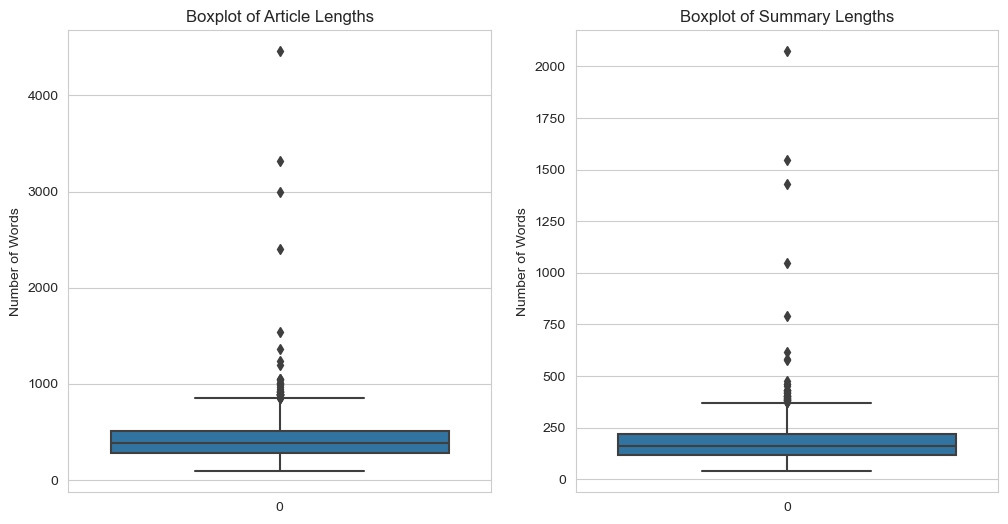

In [11]:
# Boxplots for Article and Summary Lengths
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")

In [12]:
training_dataset.describe()

,article_length,summary_length
count,1328.000000,1328.000000
mean,421.438253,179.762048
std,242.685544,110.777280
min,90.000000,38.000000
25%,280.750000,118.000000
50%,380.000000,161.000000
75%,508.250000,219.000000
max,4460.000000,2073.000000


Text(0.5, 1.0, 'Boxplot of Summary Lengths')

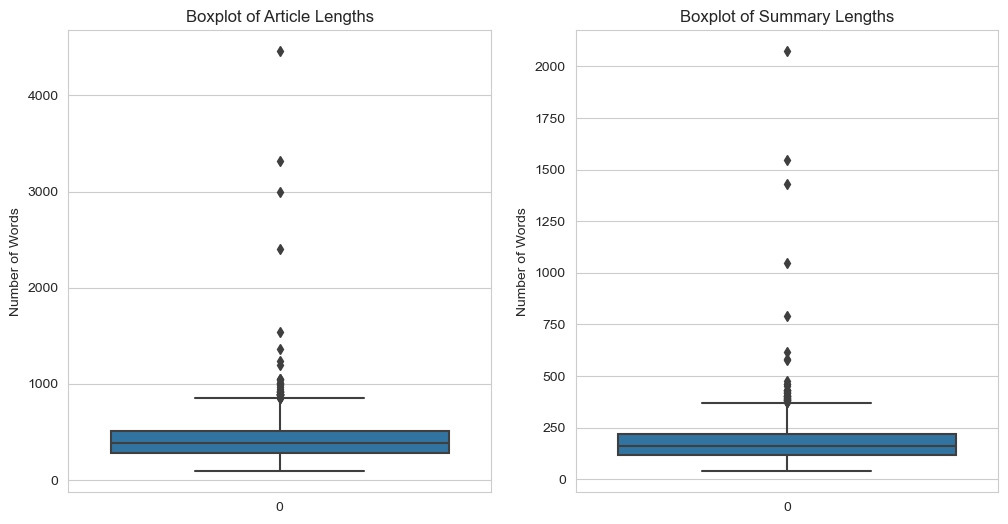

In [13]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for the articles' number of words
sns.boxplot(training_dataset["article_length"], ax=axes[0])
axes[0].set_ylabel("Number of Words")
axes[0].set_title("Boxplot of Article Lengths")

# Plot for the summaries' number of words
sns.boxplot(training_dataset["summary_length"], ax=axes[1])
axes[1].set_ylabel("Number of Words")
axes[1].set_title("Boxplot of Summary Lengths")


In [14]:
# Get statistics for the articles boxplot
lines_articles = axes[0].lines[:6]
articles_stats = [line.get_ydata()[0] for line in lines_articles]
Q1_articles, Q3_articles, lower_whisker_articles, upper_whisker_articles, median_articles = articles_stats[:5]

# Get statistics for the summaries boxplot
lines_summaries = axes[1].lines[:6]
summaries_stats = [line.get_ydata()[0] for line in lines_summaries]
Q1_summaries, Q3_summaries, lower_whisker_summaries, upper_whisker_summaries, median_summaries = summaries_stats[:5]

In [15]:
print(upper_whisker_articles)
print(upper_whisker_summaries)

849.0
369.0


In [16]:
training_dataset = training_dataset[(training_dataset['summary_length'] <= upper_whisker_summaries) & (training_dataset['article_length'] <= upper_whisker_articles)]
testing_dataset = testing_dataset[(testing_dataset['summary_length'] <= upper_whisker_summaries) & (testing_dataset['article_length'] <= upper_whisker_articles)]

In [17]:
training_dataset.head()

,filename,newsarticle,summary,article_length,summary_length
0,politics_168,MPs murder sentence concern\n\nMurder sentence...,Murder sentences should not be reduced automat...,604,286
1,tech_131,Seamen sail into biometric future\n\nThe luxur...,"She said French, Jordanian and Nigerian nation...",384,172
2,business_064,Lufthansa may sue over Bush visit\n\nGerman ai...,German airline Lufthansa may sue federal agenc...,291,151
3,business_349,S Korean lender faces liquidation\n\nCreditors...,"""Creditors would seek strong financial sanctio...",355,158
4,tech_060,Microsoft releases patches\n\nMicrosoft has wa...,Microsoft has warned PC users to update their ...,277,95


In [18]:
training_dataset.describe()

,article_length,summary_length
count,1281.000000,1281.000000
mean,394.962529,167.705699
std,151.600885,66.488051
min,90.000000,38.000000
25%,278.000000,116.000000
50%,372.000000,157.000000
75%,496.000000,209.000000
max,849.000000,369.000000


In [19]:
df = training_dataset[0:100]

In [20]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

In [21]:
# Define the device for GPU usage (if available)
if torch.backends.mps.is_available():
    arch = "mps"
elif torch.cuda.is_available():
    arch = "cuda"
else:
    arch = "cpu"

# device = torch.device(arch)
device = torch.device("cpu")

In [22]:
# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 512  # Maximum sequence length

def tokenize_text(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=512, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=280, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU

def tokenize_and_stack(df, text_column, summary_column):
    df['TokenizedText'] = df[text_column].apply(tokenize_text)
    df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)
    
    # Convert tokenized data to PyTorch tensors
    X = torch.stack([seq.squeeze() for seq in df['TokenizedText']])
    Y = torch.stack([seq.squeeze() for seq in df['TokenizedSummary']])
    
    # Define a DataLoader for batching data
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    return X, Y, dataloader

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
test_df = testing_dataset[0:len(val_df)]

# Tokenize and stack for training set
X_train, Y_train, train_dataloader = tokenize_and_stack(train_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_val, Y_val, val_dataloader = tokenize_and_stack(val_df, 'newsarticle', 'summary')

# Tokenize and stack for validation set
X_test, Y_test, test_dataloader = tokenize_and_stack(test_df, 'newsarticle', 'summary')



/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_28841/3102345579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedText'] = df[text_column].apply(tokenize_text)
/var/folders/qd/t1dpxdpn0xj2byx5h2wvvzr80000gn/T/ipykernel_28841/3102345579.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TokenizedSummary'] = df[summary_column].apply(tokenize_summary)


In [23]:
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score


def genSummaryAndEvaluate(model, dataloader):
    model.eval()
    
    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []
    bert_scores = []
    embedding_cosine_similarity = []

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            max_length=150
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=150, num_beams=17, length_penalty=2.0, early_stopping=False)
            
            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                target_text = ' '.join(target_text.split()[:max_length])
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)
                                                
                # # BERTScore
                _, _, bert_score_f1 = bert_score([output_text], [target_text], lang='en', model_type='bert-base-uncased')
                bert_scores.append(bert_score_f1.item())
                
                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    data = {
        'Article': test_articles,
        'Actual Summary': actual_summaries,
        'Predicted Summary': predicted_summaries,
        'ROUGE-1 Precision': rouge1_precision_scores,
        'BERT Score': bert_scores,

    }
    results_df = pd.DataFrame(data)
    return results_df
    # return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores


In [24]:
# Define the BART model
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Create a GradScaler for mixed-precision training
scaler = GradScaler()

# Define hyperparameters
model.to(device)  # Move the model to the GPU
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0

# Define gradient accumulation steps
accumulation_steps = 40  # You can adjust this number


/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:124: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [25]:
# Training loop
train_losses = []
rouge_scores = []
bert_scores = []
for epoch in range(3):  # Change the number of epochs as needed
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{2}")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    train_loss = total_loss / len(train_dataloader)
    train_losses.append(train_loss)
    evalResult = genSummaryAndEvaluate(model,val_dataloader)
    rouge = evalResult['ROUGE-1 Precision']
    bert = evalResult['BERT Score']
    rouge_scores.append(rouge.mean())
    bert_scores.append(bert.mean())
    print(f"Epoch {epoch+1}/{2}, Train Loss: {train_loss:.4f}, Mean Evaluation Rouge-1 Score: {rouge.mean()}, Mean Evaluation BERT Score: {bert.mean()}")

sameCategoryData = evalResult

# Save the model after training
model.save_pretrained("saved_model")

Epoch 1/2:   0%|          | 0/20 [00:00<?, ?it/s]/Users/kysgattu/anaconda3/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Evaluating Test: 100%|██████████| 5/5 [03:05<00:00, 37.17s/it]


Epoch 1/2, Train Loss: 0.3034, Mean Evaluation Rouge-1 Score: 0.4747444017860586, Mean Evaluation BERT Score: 0.6846859812736511


Evaluating Test: 100%|██████████| 5/5 [03:11<00:00, 38.30s/it]


Epoch 2/2, Train Loss: 0.3050, Mean Evaluation Rouge-1 Score: 0.4747444017860586, Mean Evaluation BERT Score: 0.6846859812736511


Evaluating Test: 100%|██████████| 5/5 [03:21<00:00, 40.31s/it]


Epoch 3/2, Train Loss: 0.3043, Mean Evaluation Rouge-1 Score: 0.47474440178605865, Mean Evaluation BERT Score: 0.6846859812736511


In [26]:
train_losses

[0.30339171886444094, 0.3049749583005905, 0.3042887657880783]

In [27]:
rouge_scores

[0.4747444017860586, 0.4747444017860586, 0.47474440178605865]

In [28]:
bert_scores

[0.6846859812736511, 0.6846859812736511, 0.6846859812736511]

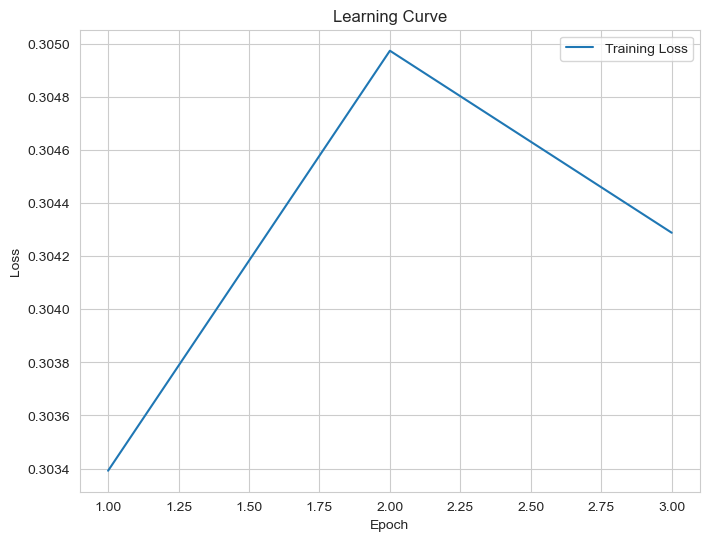

In [29]:
# Plot the Learning Curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

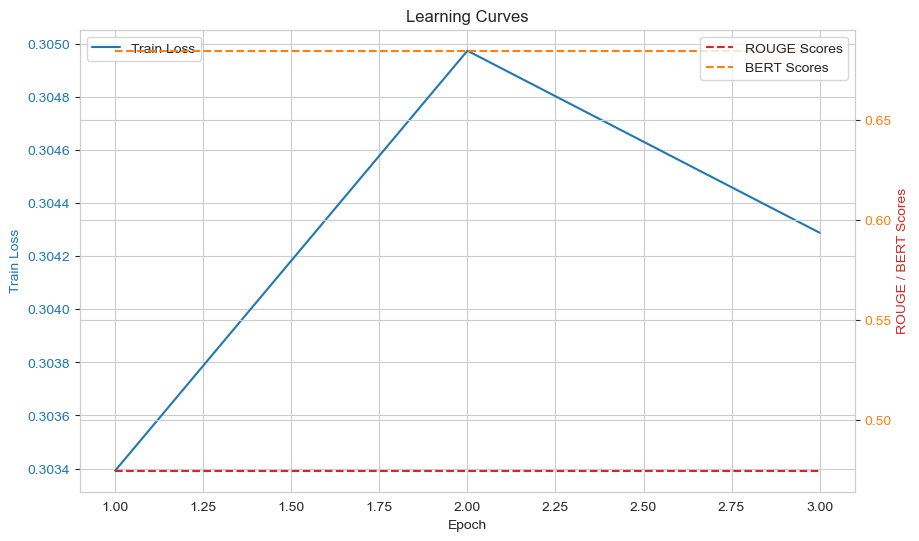

In [30]:
import matplotlib.pyplot as plt

# Example data (replace with your actual data)

# train_losses = [0.30070960372686384, 0.30086159333586693, 0.30086159333586693, 0.30086159333586693]
# 
# rouge_scores = [0.8, 0.85, 0.88, 0.92]  # Replace with your actual ROUGE scores
# bert_scores = [0.75, 0.78, 0.82, 0.86]   # Replace with your actual BERT scores
epochs = list(range(1, len(train_losses) + 1))
# Create subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot train losses on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(epochs, train_losses, color='tab:blue', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for ROUGE and BERT scores
ax2 = ax1.twinx()
ax2.set_ylabel('ROUGE / BERT Scores', color='tab:red')

# Plot ROUGE scores on the second y-axis
ax2.plot(epochs, rouge_scores, color='tab:red', linestyle='dashed', label='ROUGE Scores')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot BERT scores on the second y-axis
ax2.plot(epochs, bert_scores, color='tab:orange', linestyle='dashed', label='BERT Scores')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add legend
ax2.legend(loc='upper right')

# Show the plot
plt.title('Learning Curves')
plt.show()


sameCategoryData = genSummaryAndEvaluate(model,val_dataloader)

In [31]:
sameCategoryData[['ROUGE-1 Precision','BERT Score']]

,ROUGE-1 Precision,BERT Score
0,0.449367,0.695664
1,0.512500,0.706734
2,0.370370,0.601894
3,0.305389,0.582109
4,0.500000,0.728356
5,0.345912,0.620181
6,0.256410,0.551123
7,0.468354,0.702975
8,0.502994,0.754170
9,0.590000,0.695902


In [32]:
print(sameCategoryData['ROUGE-1 Precision'].mean(),sameCategoryData['BERT Score'].mean())

0.47474440178605865 0.6846859812736511


In [33]:
diffCategoryData = genSummaryAndEvaluate(model,test_dataloader)

Evaluating Test: 100%|██████████| 5/5 [03:16<00:00, 39.26s/it]


In [34]:
print(diffCategoryData['ROUGE-1 Precision'].mean(),diffCategoryData['BERT Score'].mean())

0.5409386278299605 0.68153185993433


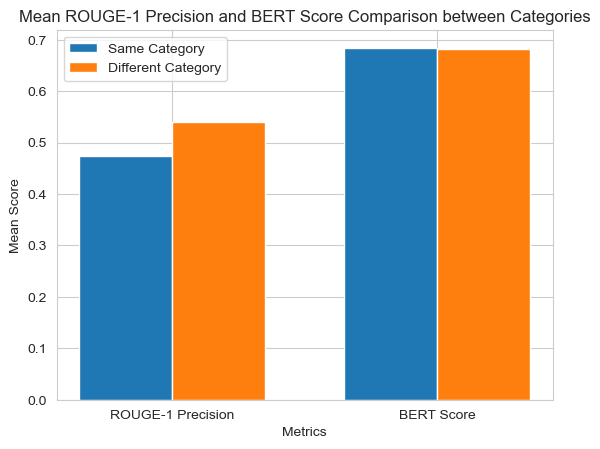

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_mean_rouge1 = sameCategoryData['ROUGE-1 Precision'].mean()
same_category_mean_bert = sameCategoryData['BERT Score'].mean()

diff_category_mean_rouge1 = diffCategoryData['ROUGE-1 Precision'].mean()
diff_category_mean_bert = diffCategoryData['BERT Score'].mean()

categories = ['ROUGE-1 Precision', 'BERT Score']
mean_scores_same_category = [same_category_mean_rouge1, same_category_mean_bert]
mean_scores_diff_category = [diff_category_mean_rouge1, diff_category_mean_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, mean_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, mean_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Score')
ax.set_title('Mean ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()


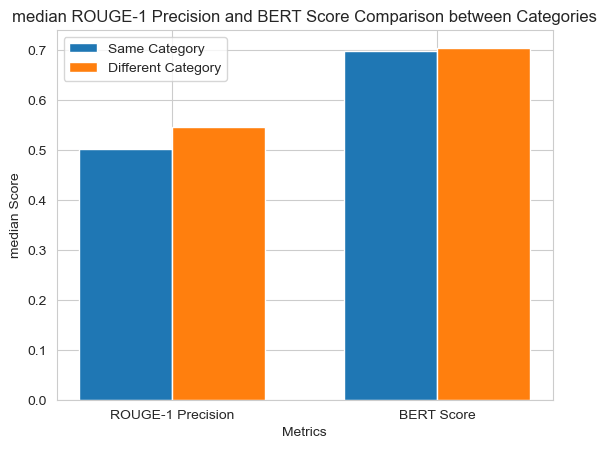

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with your actual data)
same_category_median_rouge1 = sameCategoryData['ROUGE-1 Precision'].median()
same_category_median_bert = sameCategoryData['BERT Score'].median()

diff_category_median_rouge1 = diffCategoryData['ROUGE-1 Precision'].median()
diff_category_median_bert = diffCategoryData['BERT Score'].median()

categories = ['ROUGE-1 Precision', 'BERT Score']
median_scores_same_category = [same_category_median_rouge1, same_category_median_bert]
median_scores_diff_category = [diff_category_median_rouge1, diff_category_median_bert]

bar_width = 0.35
index = np.arange(len(categories))

fig, ax = plt.subplots()
bar1 = ax.bar(index, median_scores_same_category, bar_width, label='Same Category')
bar2 = ax.bar(index + bar_width, median_scores_diff_category, bar_width, label='Different Category')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('median Score')
ax.set_title('median ROUGE-1 Precision and BERT Score Comparison between Categories')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.show()

# TO DO
> ~~Seperate Generate and Evaluate~~
> Add more Comparisions
> Rewrite code to pose different
> Write relevant coments
> Run on Full
